# $n$-step TD on a random walk

We consider a modified random Markov process (MRP) presented in example 6.2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numba import njit
from numba import prange
from tqdm import tqdm
from itertools import product

In [2]:
sns.set_palette("colorblind")

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
np.set_printoptions(linewidth=150, suppress=True, precision=4)

The state-value update using TD-1 is
$$
V(S_t) \gets V(S_t) + \alpha\left[R_{t+1} + \gamma V(S_{t+1}) - V(S_t)\right].
$$

The state-value update using TD-2 is
$$
V(S_t) \gets V(S_t) + \alpha\left[ R_{t+1} + \gamma R_{t+2} + \gamma^2 V(S_{t+2}) - V(S_t) \right].
$$

For any $n>2$, the state-value update of TD-$n$ is
$$
V(S_t) \gets V(S_t) + \alpha\left[\sum_{k=1}^n \gamma^{k-1} R_{t+k} + \gamma^n V(S_{t+n}) - V(S_t) \right].
$$

**Note**: for an episode with $T$ timesteps, if $n \geq T$, then TD reduces to an MC update.

In [5]:
n_states = 19 + 1 # total state plus terminal state
states = np.arange(n_states)
mrp = np.zeros((n_states, n_states))
mrp[0, 0] = 1.0

for i in range(1, n_states):
    iprev = i - 1
    inext = (i + 1) % n_states
    mrp[i, [i - 1, inext]] = 1/2

mrp

array([[1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0

In [6]:
n = n_states -1
reward_matrix = np.eye(n)
reward_matrix = reward_matrix - np.eye(n, k=1) / 2 - np.eye(n, k=-1) / 2
y = np.zeros(n)
y[-1] = 1/2
y[0] = -1/2

value_array = np.linalg.solve(reward_matrix, y)

In [7]:
@njit
def set_seed(seed):
    np.random.seed(seed)


@njit
def sample_run(s):
    s_hist = [s]
    r_hist = []
    r = 0
    while s != 0:
        snext = np.random.multinomial(1, mrp[s]).argmax()
        r = 1 if (s == n_states - 1) and (snext == 0) else 0
        s = snext
        s_hist.append(s)
        r_hist.append(r)
    
    s_hist = np.array(s_hist[:-1])
    r_hist = np.array(r_hist)
    return s_hist, r_hist

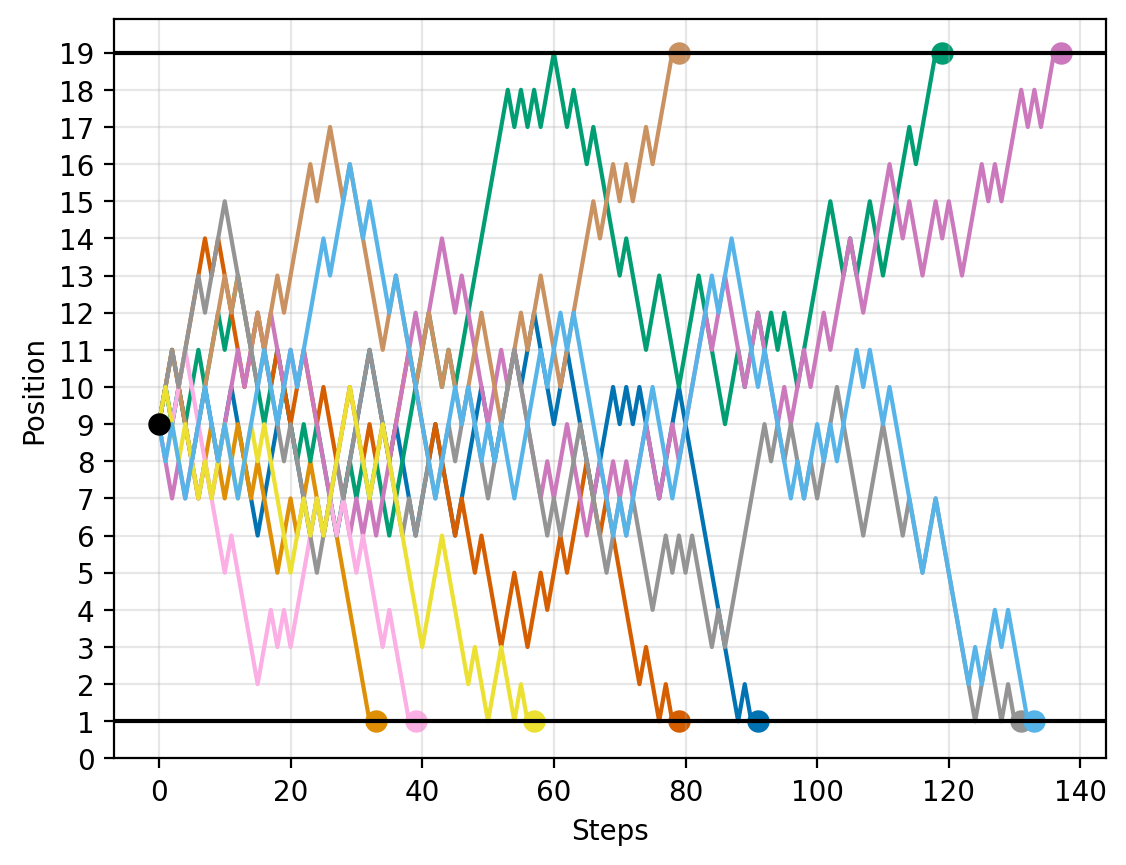

In [8]:
n_sims = 10
s_init = 9

set_seed(3141)
for n in range(n_sims):
    s_hist, r_hist = sample_run(s_init)
    len_hist = len(s_hist)
    plt.plot(s_hist)
    plt.scatter(len_hist, s_hist[-1], s=50)

plt.scatter(0, s_init, c="black", zorder=2, s=50)
plt.axhline(y=n_states - 1, c="black")
plt.axhline(y=1, c="black")
plt.ylabel("Position")
plt.xlabel("Steps")
plt.yticks(np.arange(0, n_states))
plt.grid(alpha=0.3)

In [9]:
@njit
def compute_reward(sprev, snext):
    if (sprev == n_states - 1) and (snext == 0):
        r = 1
    elif (sprev == 1) and (snext == 0):
        r = -1
    else:
        r = 0

    return r


@njit
def tdn_run_single(value, s, alpha, gamma, td_size):
    """
    Sample from the MRP and update the TD-n algorithm
    ----
    Parameters:
    value: np.array
        Current value estimate
    s: float
        initial state
    alpha: float
        learning rate
    gamma: float
        discount
    rewards_td: np.array
        FIFO buffer of rewards
    """
    value = value.copy()
    
    rewards_td = np.zeros(td_size) * np.nan # rewards in the buffer
    states_td = -np.ones(td_size, dtype=np.int32) # states S_{t+n} to update
    discount_array = gamma ** np.arange(td_size)
    discount_array = discount_array

    # Run simulation and fill buffer
    while s != 0:
        # 1. take action
        s_fwd = np.random.multinomial(1, mrp[s]).argmax()
        
        # 2. observe reward and store in buffer:
        #    include element in the last position and
        #    remove the first one.
        r = compute_reward(s, s_fwd)
        
        rewards_td = np.roll(rewards_td, -1)
        rewards_td[-1] = r
        
        # 3 If the buffer is not full, we haven't reached the pair S_τ -> S_{τ+n}.
        if not np.any(np.isnan(rewards_td)):
            # 3.1 Update state-value function with lag td_size
            s_init = states_td[0]
            target = (discount_array * rewards_td).sum() + (gamma ** td_size) * value[s_fwd]
            value[s_init] = value[s_init] + alpha * (target - value[s_init])

        states_td = np.roll(states_td, -1)
        states_td[-1] = s_fwd
        s = s_fwd

    # 4. Exhaust elements in the buffer: MC style.
    for i, s in enumerate(states_td, 1):
        # terminal or non-valid state
        if (s == -1):
            continue
        elif s == 0:
            break

        subset = rewards_td[i:]
        lsubset = len(subset)
        discounts = gamma ** np.arange(lsubset)
        G = (discounts * subset).sum()
        value[s] = value[s] + alpha * (G - value[s])

    return value


@njit
def tdn_run_episodes(value_init, state_init, alpha, gamma, td_size, n_episodes):
    value = value_init.copy()
    for e in range(n_episodes):
        value = tdn_run_single(value, state_init, alpha, gamma, td_size)
    return value


@njit(parallel=True)
def tdn_value_sims(value_init, state_init, alpha, gamma, td_size, n_episodes, n_sims):
    value_all = np.zeros((n_sims, len(value_init)))
    for n in prange(n_sims):
        value = tdn_run_episodes(value_init, state_init, alpha, gamma, td_size, n_episodes)
        value_all[n] = value
    return value_all

## Run experiment

In [10]:
value_init = np.zeros(n_states)

gamma  = 1.0
sinit = 9

n_episodes = 10
n_sims = 50

In [11]:
n_values =[2 ** n for n in range(10)]
# alpha_values = np.linspace(0, 1, 21)[:-1]
alpha_values = np.concatenate((np.linspace(0, 0.1, 10), np.linspace(0.1, 1, 20)[1:-1]))
alpha_values

array([0.    , 0.0111, 0.0222, 0.0333, 0.0444, 0.0556, 0.0667, 0.0778, 0.0889, 0.1   , 0.1474, 0.1947, 0.2421, 0.2895, 0.3368, 0.3842, 0.4316,
       0.4789, 0.5263, 0.5737, 0.6211, 0.6684, 0.7158, 0.7632, 0.8105, 0.8579, 0.9053, 0.9526])

In [12]:
def experiment(value_init, state_init, alpha_values, td_size_values, gamma, n_episodes, n_sims, n_runs):
    collection = []
    for boot in tqdm(range(n_runs)):
        for td_size, alpha in product(td_size_values, alpha_values):
            value = tdn_value_sims(value_init, state_init, alpha, gamma, td_size, n_episodes, n_sims)
            value[value == -1] = np.nan
        
            err = np.nanmean(np.power(value[:, 1:] - value_array, 2), axis=-1)
            err = np.nanmean(np.sqrt(err))

            collection.append((
                td_size, alpha, err, boot
            ))
    return collection

In [13]:
n_runs = 100
collection = experiment(
    value_init, sinit, alpha_values, n_values, gamma, n_episodes, n_sims, n_runs
)

columns = ["n", "alpha", "rmse", "boot"]

collection = [{
    col: val
    for col, val in zip(columns, entry)
} for entry in collection]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.37s/it]


In [14]:
res = pd.DataFrame(collection)

In [15]:
colors = plt.cm.viridis(np.linspace(0, 1, len(n_values)))

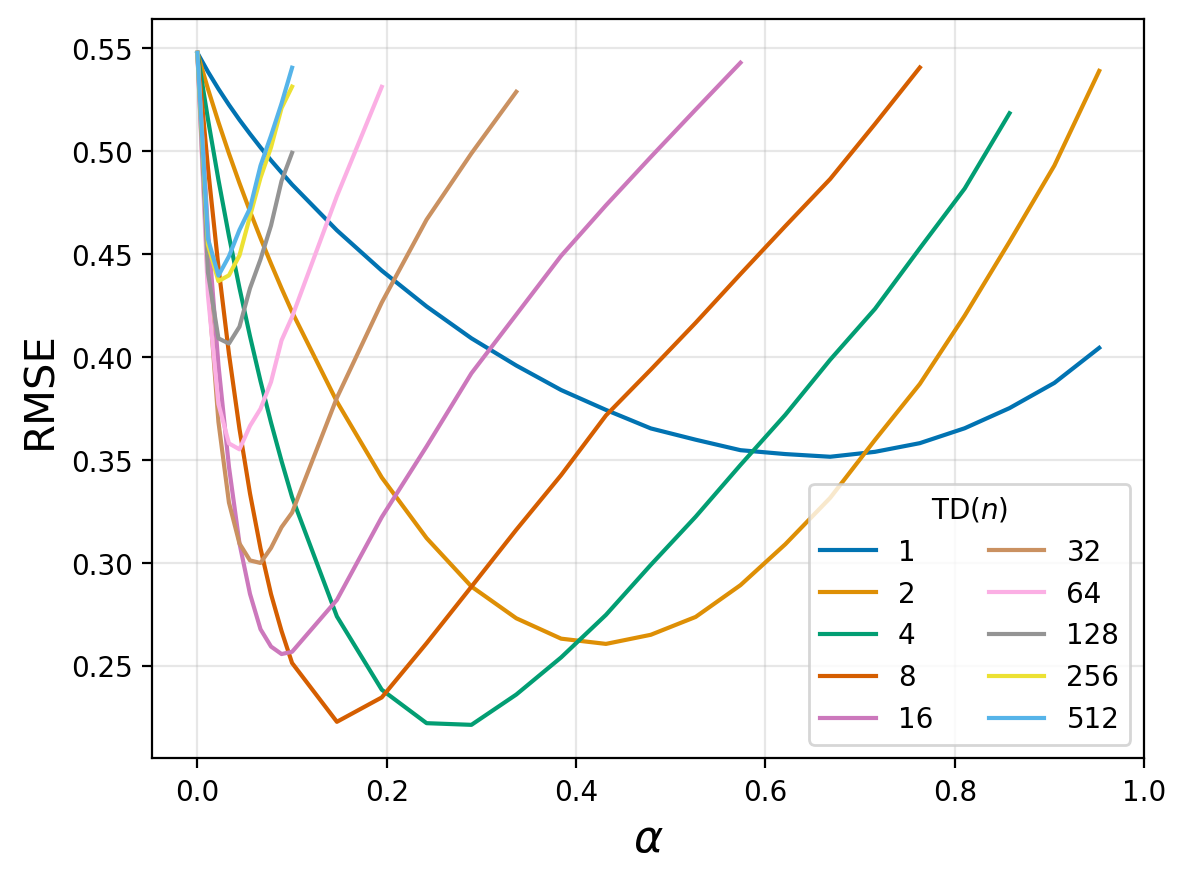

In [16]:
for c, n in zip(colors, n_values):
    res.query("n == @n").groupby("alpha")[["rmse"]].mean().query("rmse < 0.55")["rmse"].plot(label=n)
plt.grid(alpha=0.3)
plt.ylabel("RMSE", fontsize=15)
plt.legend(ncol=2, title="TD$(n)$")
plt.xlabel(r"$\alpha$", fontsize=16)
# plt.savefig("tdn-experiment.png", dpi=300)